## Import Libraries

In [2]:
import pandas as pd
from typing import List

import sqlalchemy
from sqlalchemy.engine.base import Engine
from sqlalchemy import text, create_engine

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from sqlalchemy import create_engine

from dotenv import load_dotenv

load_dotenv()

True

## Text-to-SQL Agents

The agent can:

- Parse user questions.
- Identify the relevant tables and columns.
- Generate the corresponding SQL query.
- Execute the query and return the result.

This enables non-technical users to ask questions in plain English and get data insights without writing SQL.



### Tooling and Environment Setup




#### Setting up the Database Engine

In [42]:
db_engine = create_engine(f"sqlite:///sales.db")

#### Using the Inspector

In [43]:
inspector = sqlalchemy.inspect(db_engine)
print(inspector.get_table_names())

['sales']


In [44]:
schema = inspector.get_columns(table_name)
column_names = [column["name"] for column in schema]
column_names

['id', 'transaction_date', 'model', 'price', 'quantity', 'customer_id']

#### Simple Query

In [45]:
sql = f"SELECT * FROM {table_name} LIMIT 5"

with db_engine.begin() as connection:
    answer = connection.execute(text(sql)).fetchall()

pd.DataFrame(answer, columns=column_names)

,id,transaction_date,model,price,quantity,customer_id
0,1,2024-05-22,Dell XPS 15,1308.04,4,1037
1,2,2024-06-07,Dell Inspiron 15,2399.23,4,1044
2,3,2024-12-07,Dell XPS 13,2481.61,2,1013
3,4,2024-06-21,Dell G5 15,505.98,4,1054
4,5,2024-01-04,Dell Inspiron 14,1429.78,1,1097


#### Building Database Tools

Dynamic config passing:

- Tools are environment-independent and can be re-used across databases by passing a different `db_engine` through the config.

Separation of concerns:

- Tools do not hardcode database connection logic.
- Retrieval, schema exploration, and querying are decoupled.

Foundation for Text-to-SQL agents:

- LLMs can now list tables, retrieve schema information, and execute custom SQL queries through tool calling.

##### List Tables Tool

In [46]:
@tool
def list_tables_tool(config: RunnableConfig) -> List[str]:
    """
    List all tables in database
    """
    db_engine:Engine = config.get("configurable", {}).get("db_engine")
    inspector = sqlalchemy.inspect(db_engine)

    return inspector.get_table_names()

##### Get Table Schema Tool

In [47]:
@tool
def get_table_schema_tool(table_name:str, config: RunnableConfig) -> List[str]:
    """
    Get schema information about a table. Returns a list of dictionaries.
    - name is the column name
    - type is the column type
    - nullable is whether the column is nullable or not
    - default is the default value of the column
    - primary_key is whether the column is a primary key or not

    Args:
        table_name (str): Table name
    """
    db_engine:Engine = config.get("configurable", {}).get("db_engine")
    inspector = sqlalchemy.inspect(db_engine)

    return inspector.get_columns(table_name)


##### Execute SQL Tool

In [48]:
@tool
def execute_sql_tool(query:str, config: RunnableConfig) -> int:
    """
    Execute SQL query and return result. 
    This will automatically connect to the database and execute the query.
    However, if the query is not valid, an error will be raised

    Args:
        query (str): SQL query
    """
    db_engine:Engine = config.get("configurable", {}).get("db_engine")
    with db_engine.begin() as connection:
        answer = connection.execute(text(query)).fetchall()

    return answer

#### Tool Testing

In [49]:
db_engine = create_engine(f"sqlite:///sales.db")
config = {'configurable':{'db_engine': db_engine}}

In [50]:
tables = list_tables_tool.invoke({}, config)
tables

['sales']

In [51]:
schemas = {
    table: get_table_schema_tool.invoke({
            'table_name': table
        }, config) 
    for table in tables
}
schemas

{'sales': [{'name': 'id',
   'type': INTEGER(),
   'nullable': False,
   'default': None,
   'primary_key': 1},
  {'name': 'transaction_date',
   'type': DATE(),
   'nullable': False,
   'default': None,
   'primary_key': 0},
  {'name': 'model',
   'type': VARCHAR(length=50),
   'nullable': False,
   'default': None,
   'primary_key': 0},
  {'name': 'price',
   'type': FLOAT(),
   'nullable': False,
   'default': None,
   'primary_key': 0},
  {'name': 'quantity',
   'type': INTEGER(),
   'nullable': True,
   'default': None,
   'primary_key': 0},
  {'name': 'customer_id',
   'type': INTEGER(),
   'nullable': True,
   'default': None,
   'primary_key': 0}]}

In [52]:
sql = f"SELECT * FROM {tables[0]} LIMIT 5"
result = execute_sql_tool.invoke({'query': sql}, config)
result

[(1, '2024-05-22', 'Dell XPS 15', 1308.04, 4, 1037),
 (2, '2024-06-07', 'Dell Inspiron 15', 2399.23, 4, 1044),
 (3, '2024-12-07', 'Dell XPS 13', 2481.61, 2, 1013),
 (4, '2024-06-21', 'Dell G5 15', 505.98, 4, 1054),
 (5, '2024-01-04', 'Dell Inspiron 14', 1429.78, 1, 1097)]

### State Definition

#### Initialize the State Graph
- MessageState simplifies using LangChain messages in workflows without needing custom schemas.
    - user_query: The user's natural language question.
    - messages: The conversation history.

In [54]:
class State(MessagesState):
	user_query: str

workflow = StateGraph(State)

### LLM & Tool Binding

#### Instantiate Chat Model

In [53]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

#### Binding Database Tools

We created the following tools:
- list_tables_tool: Lists tables in the database., 
- get_table_schema_tool: Retrieves the schema of a specific table, 
- execute_sql_tool: Executes the generated SQL query.

In [55]:
dba_tools = [
	list_tables_tool, 
    get_table_schema_tool, 
    execute_sql_tool
]

dba_llm = llm.bind_tools(dba_tools, tool_choice="auto")

### Agent Node Construction

#### Tool Nodes

In [56]:
workflow.add_node("dba_tools", ToolNode(dba_tools))

#### Agent Nodes

build the initial messages to start the conversation.

In [57]:
def messages_builder(state: State):
    dba_sys_msg = (
        "You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:\n"
        "First, find out the appropriate table name based on all tables. "
        "Then get the table's schema to understand the columns. "
        "With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. "
        "Finally, use a tool to execute the above SQL query and output the result based on the user question."
    )
    messages = [
        SystemMessage(dba_sys_msg),
        HumanMessage(state["user_query"])
    ]
    return {"messages": messages}

def dba_agent(state: State):
   ai_message = dba_llm.invoke(state["messages"])
   ai_message.name = "dba_agent"
   return {"messages": ai_message}


In [58]:
workflow.add_node("messages_builder", messages_builder)
workflow.add_node("dba_agent", dba_agent)

### Routing Logic

#### Edges

To enable the cycle, we need to have a routing function. This function:

- Inspects the conversation history.
- Decides whether to call a tool or end the workflow.

In [59]:
def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "dba_tools"
    return END

Then, create the edges:
- After the START entrypoint, you need to move to messages_builder
- From messages_builder, to the dba_agent
- The dba_agent should call the routing_function within a conditional edge
- If the response is a tool_call, send to dba_tools node
- Else, terminates in the END termination node.

In [60]:
workflow.add_edge(START, "messages_builder")
workflow.add_edge("messages_builder", "dba_agent")
workflow.add_conditional_edges(
    source="dba_agent", 
    path=should_continue, 
    path_map=["dba_tools", END]
)
workflow.add_edge("dba_tools", "dba_agent")

### Execution and Testing

#### Compile and Visualize

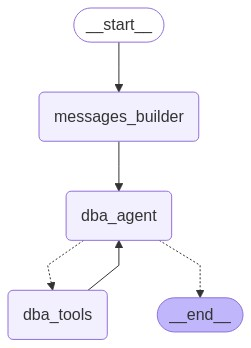

In [61]:
react_graph = workflow.compile()

display(
    Image(
        react_graph.get_graph().draw_mermaid_png()
    )
)

#### Run

In [62]:
db_engine = create_engine(f"sqlite:///sales.db")

config = {
    "configurable": {
        "db_engine": db_engine
    }
}

inputs = {"user_query": "How many Dell XPS 15 were sold?"}

messages = react_graph.invoke(inputs, config=config)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================

You are a Sr. SQL developer tasked with generating SQL queries. Perform the following steps:
First, find out the appropriate table name based on all tables. Then get the table's schema to understand the columns. With the table name and the schema, generate the ANSI SQL query you think is applicable to the user question. Finally, use a tool to execute the above SQL query and output the result based on the user question.
================================ Human Message =================================

How many Dell XPS 15 were sold?
================================== Ai Message ==================================
Name: dba_agent
Tool Calls:
  list_tables_tool (call_uiKFPnPliLIizvOuteJFpJqD)
 Call ID: call_uiKFPnPliLIizvOuteJFpJqD
  Args:
================================= Tool Message =================================
Name: list_tables_tool

["sales"]
================================== Ai Message ============